# PyMCによる重回帰分析モデルの推定
### Pythonコンピュータシミュレーション入門 ―人文・自然・社会科学の数理モデル―(P194 7.3.5 単回帰モデルを参照)
### Pythonによるベイズ統計学入門 (P78 参照、自然共役事前分布を使った手法とMCMCを使った手法で比較、P80 コード3.3、P103 コード4.1単回帰、P112 コード4.2正規分布+逆ガンマ分布、P115 コード4.3 重回帰分析)
* 線形回帰モデルにおいて切片と傾きのパラメータ：「多変量正規分布」
* 観測誤差の分散：「逆ガンマ分布」
を仮定することで、パラメータの事後分布が事前分布と同じ分布族になるため、自然共役事前分布の関係が成立

### 重回帰モデルの式 (自然共役事前分布を利用)

目的変数 $y_i$ と説明変数 $x_{ij}$ に基づいた重回帰モデルは以下の式で表されます:

$$
y_i = \beta_0 + \sum_{j=1}^{N} \beta_j x_{ij} + \varepsilon_i
$$

- $y_i$ は $i$ 番目の目的変数
- $x_{ij}$ は $i$ 番目の観測値における $j$ 番目の説明変数
- $\beta_j$ は $j$ 番目の説明変数の係数（傾き）
- $\beta_0$ は切片
- $\varepsilon_i$ は $i$ 番目の観測値の誤差項

### 目的変数 $y$ の分布

目的変数 $y$ の分布は以下のように定義されます:

$$
y \sim N\left(\mu = \beta_0 + \sum_{j=1}^{N} \beta_j x_j, \sigma^2\right)
$$

- 平均 $\mu$ は $\beta_0 + \sum_{j=1}^{N} \beta_j x_j$
- 分散 $\sigma^2$ は誤差項の分散

### 係数 $\beta$ の事前分布

係数 $\beta$（$\beta_0, \beta_1, ..., \beta_N$を含む）の事前分布には多変量正規分布を使用します。これにより、係数間の相関もモデル化できます。

$$
\beta \sim \mathcal{N}(\mu_{\beta}, \Sigma_{\beta})
$$

- $\mu_{\beta}$ は平均ベクトル
- $\Sigma_{\beta}$ は共分散行列

### 観測誤差の分散 $\sigma^2$ の事前分布

観測誤差の分散 $\sigma^2$ に対しては、逆ガンマ分布を事前分布として使用します。これにより、分散の不確実性を効果的にモデル化し、ベイジアン更新を自然共役の形で行うことができます。

$$
\sigma^2 \sim \text{Inv-Gamma}(\alpha, \beta)
$$

- $\alpha$ と $\beta$ は逆ガンマ分布のパラメータで、形状と尺度を制御します。


### モデルの設定

重回帰モデルは以下のように定義されます。

$$
y = X\beta + \epsilon
$$

ここで、
- $y$ は $ n \times 1 $ の目的変数ベクトル
- $X$ は $ n \times (p+1) $ のデザイン行列（説明変数、1列目は切片のための1が入る）
- $ \beta $ は $ (p+1) \times 1 $ の係数ベクトル
- $ \epsilon $ は $ n \times 1 $ の誤差ベクトル$( \epsilon \sim N(0, \sigma^2 I) $）

### 事前分布の設定

- 係数 \( \beta \) には多変量正規分布を事前分布として設定します。
  $$ \beta \sim N(\mu_0, \Sigma_0) $$
- 誤差項の分散 \( \sigma^2 \) には逆ガンマ分布を事前分布として設定します。
  $$ \sigma^2 \sim \text{Inv-Gamma}(\alpha_0, \beta_0) $$

### 事後分布の導出

事後分布は次のように計算されます。まず、尤度関数は
$$ p(y | X, \beta, \sigma^2) = (2\pi \sigma^2)^{-\frac{n}{2}} \exp\left(-\frac{1}{2\sigma^2} (y - X\beta)^T (y - X\beta)\right) $$
これと事前分布を組み合わせて、事後分布を得ることができます。

#### 係数 $ \beta $ の事後分布
$$ \beta | y, X, \sigma^2 \sim N(\mu_n, \Sigma_n) $$
ここで、
$$ \Sigma_n = (\Sigma_0^{-1} + X^T X / \sigma^2)^{-1} $$
$$ \mu_n = \Sigma_n (\Sigma_0^{-1} \mu_0 + X^T y / \sigma^2) $$

#### 誤差の分散 \( \sigma^2 \) の事後分布
$$ \sigma^2 | y, X, \beta \sim \text{Inv-Gamma}(\alpha_n, \beta_n) $$
ここで、
$$ \alpha_n = \alpha_0 + \frac{n}{2} $$
$$ \beta_n = \beta_0 + \frac{1}{2} (y - X\beta)^T (y - X\beta) $$

これらの式は、ベイズ推定の解析的な解として用いることができ、サンプリングによる近似を使用する必要がなくなります。


In [1]:
# -*- coding: utf-8 -*-
import pymc as pm
import numpy as np
import scipy.stats as st
import scipy.optimize as opt
import scipy.linalg as la
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import pymc as pm
%matplotlib inline

In [2]:
#日本語対応
!pip install japanize-matplotlib
import japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=cc9f140643a4d73fd40aed3723ccaf886cc5d6c65463e049327df3f982d1e6d8
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


### Pythonによるベイズ統計学入門 P80 コード3.3 自然共役事前分布を用いた回帰分析
係数$\beta$の事前分布には正規分布、観測誤差の事前分布には逆ガンマ分布を設定

In [3]:
#この関数 invgamma_hpdi は、逆ガンマ分布の高確率密度区間（HPDI: Highest Posterior Density Interval）を計算するために使用されます。
def invgamma_hpdi(hpdi0, alpha, beta, prob):
    """
        入力
        hpdi0:  HPD区間の初期値
        alpha:  逆ガンマ分布の形状パラメータ
        beta:   逆ガンマ分布の尺度パラメータ
        prob:   HPD区間の確率 (0 < prob < 1)
        出力
        HPD区間
    """
    def hpdi_conditions(v, a, b, p):
        """
            入力
            v:  HPD区間
            a:  逆ガンマ分布の形状パラメータ
            b:  逆ガンマ分布の尺度パラメータ
            p:  HPD区間の確率 (0 < p < 1)
            出力
            HPD区間の条件式の値
        """
        eq1 = st.invgamma.cdf(v[1], a, scale=b) \
              - st.invgamma.cdf(v[0], a, scale=b) - p
        eq2 = st.invgamma.pdf(v[1], a, scale=b) \
              - st.invgamma.pdf(v[0], a, scale=b)
        return np.hstack((eq1, eq2))
    return opt.root(hpdi_conditions, hpdi0, args=(alpha, beta, prob)).x

In [4]:
#   回帰モデルの係数と誤差項の分散の事後統計量の計算
def regression_stats(y, X, b0, A0, nu0, lam0, prob):
    """
        入力
        y:      被説明変数
        X:      説明変数
        b0:     回帰係数の条件付事前分布（多変量正規分布）の平均
        A0:     回帰係数の条件付事前分布（多変量正規分布）の精度行列
        nu0:    誤差項の分散の事前分布（逆ガンマ分布）の形状パラメータ
        lam0:   誤差項の分散の事前分布（逆ガンマ分布）の尺度パラメータ
        prob:   区間確率 (0 < prob < 1)
        出力
        results:    事後統計量のデータフレーム
        b_star:     回帰係数の条件付事後分布（多変量正規分布）の平均
        A_star:     回帰係数の条件付事後分布（多変量正規分布）の精度行列
        nu_star:    誤差項の分散の事後分布（逆ガンマ分布）の形状パラメータ
        lam_star:   誤差項の分散の事後分布（逆ガンマ分布）の尺度パラメータ
    """
    XX = X.T.dot(X)
    Xy = X.T.dot(y)
    b_ols = la.solve(XX, Xy)
    A_star = XX + A0
    b_star = la.solve(A_star, Xy + A0.dot(b0))
    C_star = la.inv(la.inv(XX) + la.inv(A0))
    nu_star = y.size + nu0
    lam_star =  np.square(y - X.dot(b_ols)).sum() \
                + (b0 - b_ols).T.dot(C_star).dot(b0 - b_ols) + lam0
    h_star = np.sqrt(lam_star / nu_star * np.diag(la.inv(A_star)))
    sd_b = st.t.std(nu_star, loc=b_star, scale=h_star)
    ci_b = np.vstack(st.t.interval(prob, nu_star, loc=b_star, scale=h_star))
    hpdi_b = ci_b
    stats_b = np.vstack((b_star, b_star, b_star, sd_b, ci_b, hpdi_b)).T
    mean_sigma2 = st.invgamma.mean(0.5*nu_star, scale=0.5*lam_star)
    median_sigma2 = st.invgamma.median(0.5*nu_star, scale=0.5*lam_star)
    mode_sigma2 = lam_star / (nu_star + 2.0)
    sd_sigma2 = st.invgamma.std(0.5*nu_star, scale=0.5*lam_star)
    ci_sigma2 = st.invgamma.interval(prob, 0.5*nu_star, scale=0.5*lam_star)
    hpdi_sigma2 = invgamma_hpdi(ci_sigma2, 0.5*nu_star, 0.5*lam_star, prob)
    stats_sigma2 = np.hstack((mean_sigma2, median_sigma2, mode_sigma2,
                              sd_sigma2, ci_sigma2, hpdi_sigma2))
    stats = np.vstack((stats_b, stats_sigma2))
    stats_string = ['平均', '中央値', '最頻値', '標準偏差', '信用区間（下限）',
                    '信用区間（上限）', 'HPD区間（下限）', 'HPD区間（上限）']
    param_string = ['切片 $\\alpha$', '傾き $\\beta$', '分散 $\\sigma^2$']
    results = pd.DataFrame(stats, index=param_string, columns=stats_string)
    return results, b_star, h_star, nu_star, lam_star

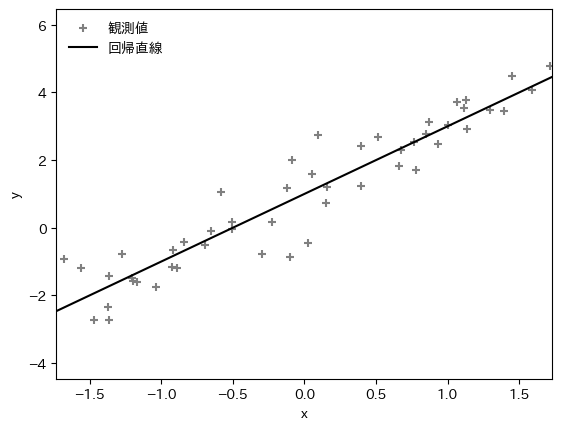

                  平均    中央値    最頻値   標準偏差  信用区間（下限）  信用区間（上限）  HPD区間（下限）  HPD区間（上限）
切片 $\alpha$   0.9990 0.9990 0.9990 0.1082    0.7861    1.2119     0.7861     1.2119
傾き $\beta$    2.0032 2.0032 2.0032 0.1113    1.7843    2.2222     1.7843     2.2222
分散 $\sigma^2$ 0.5872 0.5728 0.5460 0.1163    0.4022    0.8551     0.3815     0.8203


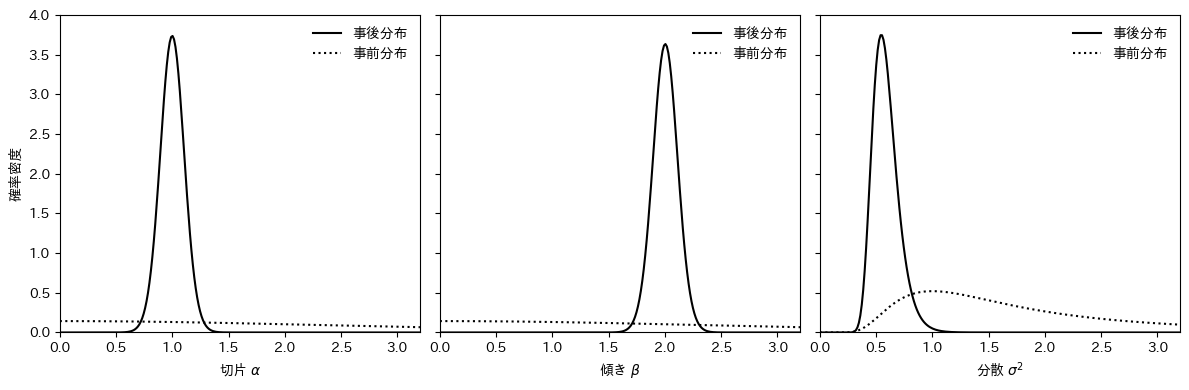

In [5]:
#%% 回帰モデルからのデータの生成
n = 50
np.random.seed(99)
u = st.norm.rvs(scale=0.7, size=n)
x = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
y = 1.0 + 2.0 * x + u
X = np.stack((np.ones(n), x), axis=1)
fig1 = plt.figure(num=1, facecolor='w')
plt.scatter(x, y, color='0.5', marker='+', label='観測値')
x_range = (-np.sqrt(3.0), np.sqrt(3.0))
y_range = (1.0 - 2.0*np.sqrt(3.0), 1.0 + 2.0*np.sqrt(3.0))
plt.plot(x_range, y_range, 'k-', label='回帰直線')
plt.xlim(x_range)
plt.ylim(y_range[0] - 2.0, y_range[1] + 2.0)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper left', frameon=False)
plt.savefig('pybayes_fig_regression_scatter.png', dpi=300)
plt.show()
#%% 事後統計量の計算
b0 = np.zeros(2)
A0 = 0.2 * np.eye(2)
nu0 = 5.0
lam0 = 7.0
h0 = np.sqrt(np.diag(lam0 / nu0 * la.inv(A0)))
prob = 0.95
results, b_star, h, nu_star, lam_star = regression_stats(y, X, b0, A0, nu0,
                                                         lam0, prob)
print(results.to_string(float_format='{:,.4f}'.format))
#%% 事後分布のグラフの作成
labels = ['切片 $\\alpha$', '傾き $\\beta$', '分散 $\\sigma^2$']
fig2, ax2 = plt.subplots(1, 3, sharey='all', sharex='all',
                         num=2, figsize=(12, 4), facecolor='w')
x = np.linspace(0, 3.2, 250)
ax2[0].set_xlim(0, 3.2)
ax2[0].set_ylim(0, 4)
ax2[0].set_ylabel('確率密度')
for index in range(3):
    if index < 2:
        posterior = st.t.pdf(x, nu_star, loc=b_star[index], scale=h[index])
        prior = st.t.pdf(x, nu0, loc=b0[index], scale=h0[index])
    else:
        posterior = st.invgamma.pdf(x, 0.5*nu_star, scale=0.5*lam_star)
        prior = st.invgamma.pdf(x, 0.5*nu0, scale=0.5*lam0)
    ax2[index].plot(x, posterior, 'k-', label='事後分布')
    ax2[index].plot(x, prior, 'k:', label='事前分布')
    ax2[index].set_xlabel(labels[index])
    ax2[index].legend(loc='best', frameon=False)
plt.tight_layout()
plt.savefig('pybayes_fig_regression_posterior.png', dpi=300)
plt.show()

### Pythonによるベイズ統計学入門 P103 コード4.1 自然共役事前分布を用いた回帰分析をMCMCでやってみたもの
係数$\beta$の事前分布には正規分布、観測誤差の事前分布には逆ガンマ分布を設定($\beta$と$\sigma^2$は依存関係にある)

In [6]:
#%% 回帰モデルからのデータ生成
n = 50
np.random.seed(99)
u = st.norm.rvs(scale=0.7, size=n)
x = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
y = 1.0 + 2.0 * x + u
#%% 回帰モデルの係数と誤差項の分散の事後分布の設定（自然共役事前分布）
b0 = np.zeros(2)
A0 = 0.2 * np.eye(2)
nu0 = 5.0
lam0 = 7.0
h0 = np.sqrt(np.diag(lam0 / nu0 * la.inv(A0)))
sd0 = np.sqrt(np.diag(la.inv(A0)))

In [7]:
regression_conjugate = pm.Model()
with regression_conjugate:
    sigma2 = pm.InverseGamma('sigma2', alpha=0.5*nu0, beta=0.5*lam0)
    sigma = pm.math.sqrt(sigma2)
    a = pm.Normal('a', mu=b0[0], sigma=sigma*sd0[0])
    b = pm.Normal('b', mu=b0[1], sigma=sigma*sd0[1])
    y_hat = a + b * x
    likelihood = pm.Normal('y', mu=y_hat, sigma=sigma, observed=y)

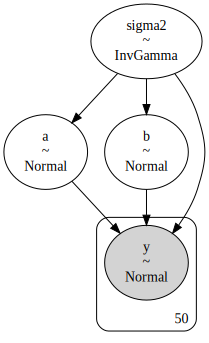

In [8]:
tree_model = pm.model_to_graphviz(regression_conjugate)
tree_model
#木構造の図をPNGで保存したい場合には，次の行のコメントをはずす
#tree_model.render(filename='fig_Bayes_PyMC3_Regre_TreeModel', format='png') # DOT言語ファイルと画像ファイルの保存

In [11]:
#%% 事後分布からのサンプリング
n_draws = 5000
n_chains = 4
n_tune = 1000
with regression_conjugate:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune,
                      random_seed=123)
    print(pm.summary(trace))

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a       0.999  0.108   0.800    1.205      0.001    0.000   28649.0   15217.0   
b       2.002  0.112   1.790    2.214      0.001    0.001   24334.0   14801.0   
sigma2  0.587  0.117   0.384    0.807      0.001    0.001   24696.0   14290.0   

        r_hat  
a         1.0  
b         1.0  
sigma2    1.0  


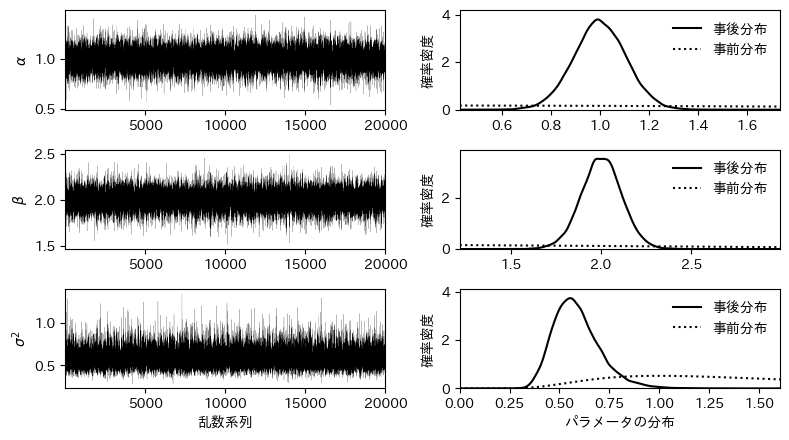

In [12]:
#%% 事後分布のグラフの作成
k = b0.size
param_names = ['a', 'b', 'sigma2']
labels = ['$\\alpha$', '$\\beta$', '$\\sigma^2$']
fig, ax = plt.subplots(k+1, 2, num=1, figsize=(8, 1.5*(k+1)), facecolor='w')
for index in range(k+1):
    mc_trace = trace.posterior[param_names[index]].values.flatten()
    if index < k:
        x_min = mc_trace.min() - 0.2 * np.abs(mc_trace.min())
        x_max = mc_trace.max() + 0.2 * np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.norm.pdf(x, loc=b0[index], scale=sd0[index])
    else:
        x_min = 0.0
        x_max = mc_trace.max() + 0.2 * np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.invgamma.pdf(x, 0.5*nu0, scale=0.5*lam0)
        ax[index, 0].set_xlabel('乱数系列')
        ax[index, 1].set_xlabel('パラメータの分布')
    ax[index, 0].plot(mc_trace, 'k-', linewidth=0.1)
    ax[index, 0].set_xlim(1, n_draws*n_chains)
    ax[index, 0].set_ylabel(labels[index])
    posterior = st.gaussian_kde(mc_trace).evaluate(x)
    ax[index, 1].plot(x, posterior, 'k-', label='事後分布')
    ax[index, 1].plot(x, prior, 'k:', label='事前分布')
    ax[index, 1].set_xlim(x_min, x_max)
    ax[index, 1].set_ylim(0, 1.1*posterior.max())
    ax[index, 1].set_ylabel('確率密度')
    ax[index, 1].legend(loc='best', frameon=False)
plt.tight_layout()
plt.savefig('pybayes_fig_mcmc_reg_ex1.png', dpi=300)
plt.show()

### Pythonによるベイズ統計学入門 P112 コード4.2 自然共役事前分布を用いることができない回帰分析(MCMCで実施)
aとbの事前分布の尺度パラメタはsigmaに依存しない($\beta$と$\sigma^2$は独立)  
$\beta$の事前分布は正規分布、$sigma^2$の事前分布は逆ガンマ分布だが、$\beta$と$\sigma^2$は独立

In [13]:
#%% 回帰モデルからのデータ生成
n = 50
np.random.seed(99)
u = st.norm.rvs(scale=0.7, size=n)
x = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
y = 1.0 + 2.0 * x + u
#%% 回帰モデルの係数と誤差項の分散の事後分布の設定（正規分布＋逆ガンマ分布）
b0 = np.zeros(2)
A0 = 0.2 * np.eye(2)
nu0 = 5.0
lam0 = 7.0
sd0 = np.sqrt(np.diag(la.inv(A0)))

In [14]:
regresssion_normal_invgamma = pm.Model()
with regresssion_normal_invgamma:
    sigma2 = pm.InverseGamma('sigma2', alpha=0.5*nu0, beta=0.5*lam0)
    a = pm.Normal('a', mu=0.0, sigma=sd0[0])
    b = pm.Normal('b', mu=0.0, sigma=sd0[1])
    y_hat = a + b * x
    likelihood = pm.Normal('y', mu=y_hat, sigma=pm.math.sqrt(sigma2),
                           observed=y)

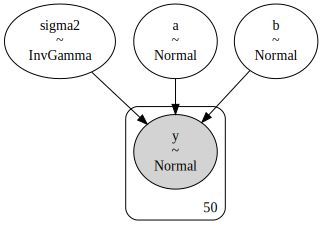

In [15]:
tree_model = pm.model_to_graphviz(regresssion_normal_invgamma)
tree_model
#木構造の図をPNGで保存したい場合には，次の行のコメントをはずす
#tree_model.render(filename='fig_Bayes_PyMC3_Regre_TreeModel', format='png') # DOT言語ファイルと画像ファイルの保存

In [16]:
#%% 事後分布からのサンプリング
n_draws = 5000
n_chains = 4
n_tune = 1000
with regresssion_normal_invgamma:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune,
                      random_seed=123)
    print(pm.summary(trace))

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a       1.000  0.108   0.802    1.208      0.001    0.000   27433.0   15587.0   
b       2.006  0.111   1.808    2.223      0.001    0.000   24773.0   15799.0   
sigma2  0.590  0.118   0.381    0.807      0.001    0.001   24657.0   16048.0   

        r_hat  
a         1.0  
b         1.0  
sigma2    1.0  


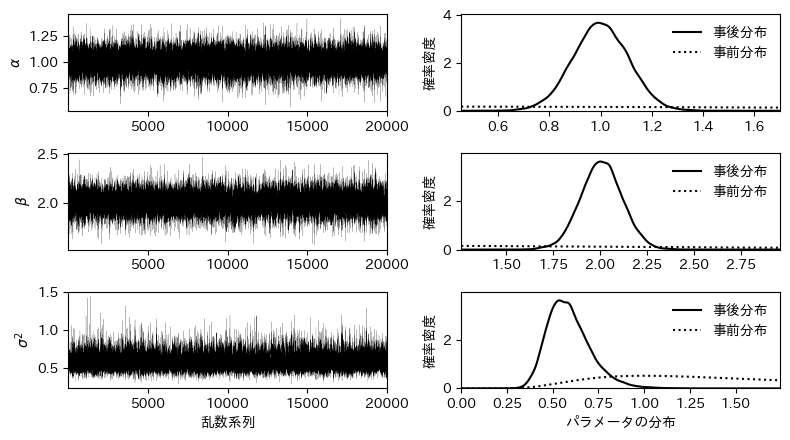

In [20]:
#%% 事後分布のグラフの作成
k = b0.size
param_names = ['a', 'b', 'sigma2']
labels = ['$\\alpha$', '$\\beta$', '$\\sigma^2$']
fig, ax = plt.subplots(k+1, 2, num=1, figsize=(8, 1.5*(k+1)), facecolor='w')
for index in range(k+1):
    mc_trace = trace.posterior[param_names[index]].values.flatten()
    if index < k:
        x_min = mc_trace.min() - 0.2 * np.abs(mc_trace.min())
        x_max = mc_trace.max() + 0.2 * np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.norm.pdf(x, loc=b0[index], scale=sd0[index])
    else:
        x_min = 0.0
        x_max = mc_trace.max() + 0.2 * np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.invgamma.pdf(x, 0.5*nu0, scale=0.5*lam0)
        ax[index, 0].set_xlabel('乱数系列')
        ax[index, 1].set_xlabel('パラメータの分布')
    ax[index, 0].plot(mc_trace, 'k-', linewidth=0.1)
    ax[index, 0].set_xlim(1, n_draws*n_chains)
    ax[index, 0].set_ylabel(labels[index])
    posterior = st.gaussian_kde(mc_trace).evaluate(x)
    ax[index, 1].plot(x, posterior, 'k-', label='事後分布')
    ax[index, 1].plot(x, prior, 'k:', label='事前分布')
    ax[index, 1].set_xlim(x_min, x_max)
    ax[index, 1].set_ylim(0, 1.1*posterior.max())
    ax[index, 1].set_ylabel('確率密度')
    ax[index, 1].legend(loc='best', frameon=False)
plt.tight_layout()
plt.savefig('pybayes_fig_mcmc_reg_ex2.png', dpi=300)
plt.show()

### Pythonによるベイズ統計学入門 P115 コード4.3 回帰係数に多変量正規分布、観測誤差の分散に逆ガンマ分布を仮定(MCMCで実施)

In [17]:
#%% 回帰モデルからのデータ生成
n = 50
np.random.seed(99)
u = st.norm.rvs(scale=0.7, size=n)
x1 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
x2 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
y = 1.0 + 2.0 * x1 - x2 + u
X = np.stack((np.ones(n), x1, x2), axis=1)
#%% 回帰モデルの係数と誤差項の分散の事後分布の設定
k = X.shape[1]
b0 = np.zeros(k)
A0 = 0.2 * np.eye(k)
nu0 = 5.0
lam0 = 7.0
sd0 = np.sqrt(np.diag(la.inv(A0)))

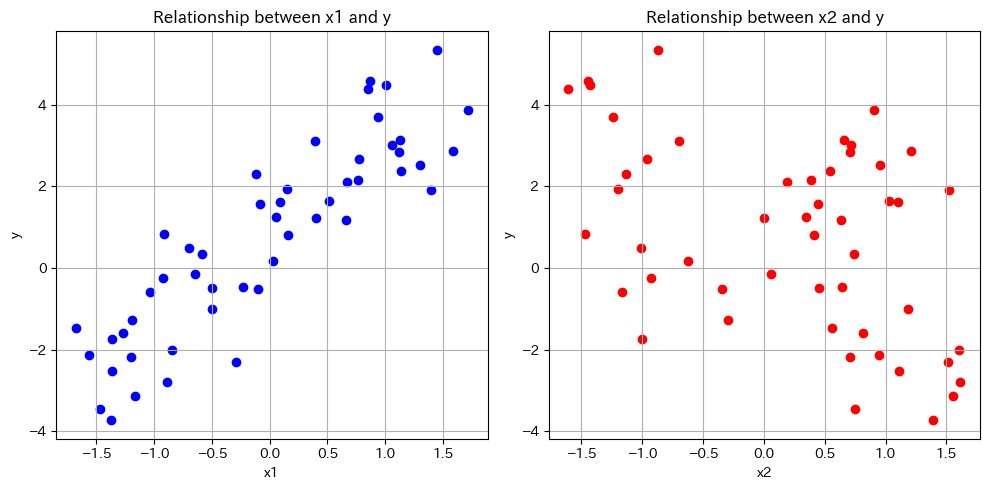

In [23]:
# x1 と y の関係をプロット
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(x1, y, color='blue')
plt.title('Relationship between x1 and y')
plt.xlabel('x1')
plt.ylabel('y')
plt.grid()

# x2 と y の関係をプロット
plt.subplot(1, 2, 2)
plt.scatter(x2, y, color='red')
plt.title('Relationship between x2 and y')
plt.xlabel('x2')
plt.ylabel('y')

plt.tight_layout()
plt.grid()
plt.show()


In [18]:
multiple_regression = pm.Model()
with multiple_regression:
    sigma2 = pm.InverseGamma('sigma2', alpha=0.5*nu0, beta=0.5*lam0)
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    y_hat = pm.math.dot(X, b)
    likelihood = pm.Normal('y', mu=y_hat, sigma=pm.math.sqrt(sigma2),
                           observed=y)

In [25]:
#%% 事後分布からのサンプリング
n_draws = 5000
n_chains = 4
n_tune = 1000
with multiple_regression:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)
    map_estimate = pm.find_MAP()
    print(pm.summary(trace))


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
b[0]    0.974  0.109   0.775    1.186      0.001    0.000   24226.0   16526.0   
b[1]    2.023  0.112   1.810    2.231      0.001    0.001   22456.0   15020.0   
b[2]   -0.867  0.112  -1.079   -0.657      0.001    0.000   26451.0   16350.0   
sigma2  0.585  0.119   0.382    0.810      0.001    0.001   26839.0   14450.0   

        r_hat  
b[0]      1.0  
b[1]      1.0  
b[2]      1.0  
sigma2    1.0  


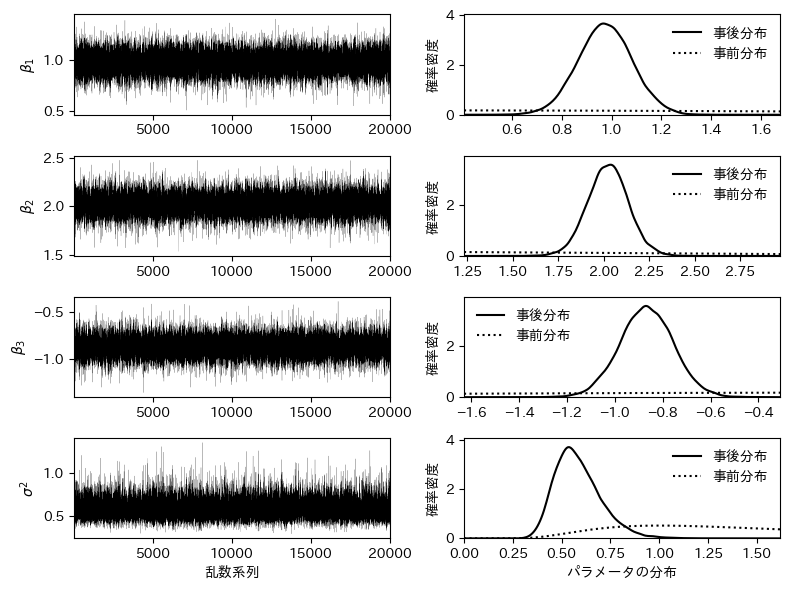

MAP Estimates:
Estimated b: [ 0.97542685  2.02237024 -0.86784871]
Estimated sigma2: 0.5144973031901241

True values used for generating data:
True beta coefficients: [1.0, 2.0, -1.0]
True sigma2 (variance of u): 0.49

Errors in estimation:
Error in beta coefficients: [-0.02457315  0.02237024  0.13215129]
Error in sigma2: 0.02449730319012411


In [28]:
#%% 事後分布のグラフの作成
fig, ax = plt.subplots(k+1, 2, num=1, figsize=(8, 1.5*(k+1)), facecolor='w')
for index in range(k+1):
    if index < k:
        mc_trace = trace.posterior['b'].values[:, :, index].flatten()
        x_min = mc_trace.min() - 0.2 * np.abs(mc_trace.min())
        x_max = mc_trace.max() + 0.2 * np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.norm.pdf(x, loc=b0[index], scale=sd0[index])
        y_label = '$\\beta_{:<d}$'.format(index+1)
    else:
        mc_trace = trace.posterior['sigma2'].values.flatten()
        x_min = 0.0
        x_max = mc_trace.max() + 0.2 * np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.invgamma.pdf(x, 0.5*nu0, scale=0.5*lam0)
        y_label = '$\\sigma^2$'
        ax[index, 0].set_xlabel('乱数系列')
        ax[index, 1].set_xlabel('パラメータの分布')
    ax[index, 0].plot(mc_trace, 'k-', linewidth=0.1)
    ax[index, 0].set_xlim(1, n_draws*n_chains)
    ax[index, 0].set_ylabel(y_label)
    posterior = st.gaussian_kde(mc_trace).evaluate(x)
    ax[index, 1].plot(x, posterior, 'k-', label='事後分布')
    ax[index, 1].plot(x, prior, 'k:', label='事前分布')
    ax[index, 1].set_xlim(x_min, x_max)
    ax[index, 1].set_ylim(0, 1.1*posterior.max())
    ax[index, 1].set_ylabel('確率密度')
    ax[index, 1].legend(loc='best', frameon=False)
plt.tight_layout()
plt.savefig('pybayes_fig_mcmc_reg_ex3.png', dpi=300)
plt.show()

# 推定値の取得
print("MAP Estimates:")
print("Estimated b:", map_estimate['b'])
print("Estimated sigma2:", map_estimate['sigma2'])

# 設定値との比較
print("\nTrue values used for generating data:")
print("True beta coefficients: [1.0, 2.0, -1.0]")  # 真の係数
print("True sigma2 (variance of u):", 0.49)  # uの分散は 0.7^2

# 誤差の計算
errors = map_estimate['b'] - np.array([1.0, 2.0, -1.0])
error_sigma2 = map_estimate['sigma2'] - 0.49
print("\nErrors in estimation:")
print("Error in beta coefficients:", errors)
print("Error in sigma2:", error_sigma2)

###Pythonによるベイズ統計学入門 P117 コード4.4 回帰係数にラプラス分布、観測誤差の分散に半コーシー分布を仮定(MCMCで実施)
回帰係数の事前分布に
* 多変量正規分布を仮定-> Ridge回帰(L2正則化)と同等なモデルになる
* ラプラス分布を仮定-> Lasso回帰(L1正則化)と同等なモデルになる

In [30]:
#%% 回帰モデルからのデータ生成
n = 50
np.random.seed(99)
u = st.norm.rvs(scale=0.7, size=n)
x = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
y = 1.0 + 2.0 * x + u
#%% 回帰モデルの係数と誤差項の分散の事後分布の設定（ラプラス＋半コーシー分布）
b0 = np.zeros(2)
tau_coef = np.ones(2)
tau_sigma = 1.0

In [31]:
regression_laplace_halfcauchy = pm.Model()
with regression_laplace_halfcauchy:
    sigma = pm.HalfCauchy('sigma', beta=tau_sigma)
    a = pm.Laplace('a', mu=b0[0], b=tau_coef[0])
    b = pm.Laplace('b', mu=b0[1], b=tau_coef[1])
    y_hat = a + b * x
    likelihood = pm.Normal('y', mu=y_hat, sigma=sigma, observed=y)

In [32]:
#%% 事後分布からのサンプリング
n_draws = 5000
n_chains = 4
n_tune = 1000
with regression_laplace_halfcauchy:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)
    map_estimate = pm.find_MAP()
    print(pm.summary(trace))


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a      0.993  0.101   0.806    1.183      0.001      0.0   27111.0   15637.0   
b      2.000  0.104   1.809    2.204      0.001      0.0   27404.0   15830.0   
sigma  0.708  0.074   0.574    0.846      0.000      0.0   23530.0   14177.0   

       r_hat  
a        1.0  
b        1.0  
sigma    1.0  


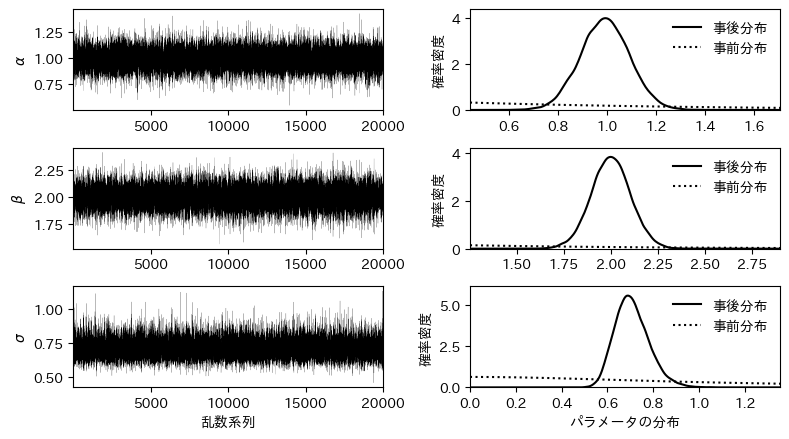

MAP Estimates:
Estimated b: 0.9938360791822305
Estimated b: 2.001850605420664
Estimated sigma: 0.6758596267218923

True values used for generating data:
True beta coefficients: [1.0, 2.0]
True sigma (variance of u): 0.7


In [36]:
#%% 事後分布のグラフの作成
k = b0.size
param_names = ['a', 'b', 'sigma']
labels = ['$\\alpha$', '$\\beta$', '$\\sigma$']
fig, ax = plt.subplots(k+1, 2, num=1, figsize=(8, 1.5*(k+1)), facecolor='w')
for index in range(k+1):
    mc_trace = trace.posterior[param_names[index]].values.flatten()
    if index < k:
        x_min = mc_trace.min() - 0.2 * np.abs(mc_trace.min())
        x_max = mc_trace.max() + 0.2 * np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.laplace.pdf(x, loc=b0[index], scale=tau_coef[index])
    else:
        x_min = 0.0
        x_max = mc_trace.max() + 0.2 * np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.halfcauchy.pdf(x, scale=tau_sigma)
        ax[index, 0].set_xlabel('乱数系列')
        ax[index, 1].set_xlabel('パラメータの分布')
    ax[index, 0].plot(mc_trace, 'k-', linewidth=0.1)
    ax[index, 0].set_xlim(1, n_draws*n_chains)
    ax[index, 0].set_ylabel(labels[index])
    posterior = st.gaussian_kde(mc_trace).evaluate(x)
    ax[index, 1].plot(x, posterior, 'k-', label='事後分布')
    ax[index, 1].plot(x, prior, 'k:', label='事前分布')
    ax[index, 1].set_xlim(x_min, x_max)
    ax[index, 1].set_ylim(0, 1.1*posterior.max())
    ax[index, 1].set_ylabel('確率密度')
    ax[index, 1].legend(loc='best', frameon=False)
plt.tight_layout()
plt.savefig('pybayes_fig_mcmc_reg_ex4.png', dpi=300)
plt.show()

# 推定値の取得
print("MAP Estimates:")
print("Estimated b:", map_estimate['a'])
print("Estimated b:", map_estimate['b'])
print("Estimated sigma:", map_estimate['sigma'])

# 設定値との比較
print("\nTrue values used for generating data:")
print("True beta coefficients: [1.0, 2.0]")  # 真の係数
print("True sigma (variance of u):", 0.7)  # uの分散は 0.7^2

